In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, torch
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../")))
from libs import data, hdc, helper, nn, sim
from cfgs.fedargs import *

In [3]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [4]:
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, **kwargs)

In [5]:
fedargs.model = hdc.HDC(fedargs.one_d_len, fedargs.hdc_proj_len, len(fedargs.labels), device)

In [6]:
# Train    
train_acc = fedargs.model.train(train_loader, device)
#fedargs.model.load_state_dict(torch.load('hdc.pth'))

In [7]:
# Test, Plot and Log
test_acc = fedargs.model.test(test_loader, device)

In [8]:
hdc_train_vectors = fedargs.model.train_vectors

In [9]:
#print(train_acc, test_acc)
print(test_acc)

82.2300033569336


In [10]:
model = nn.ModelMNIST()

In [11]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True, **kwargs)

In [12]:
'''
# Train
from tqdm import tqdm

fedargs.epochs = 5
fedargs.local_rounds = 1
for epoch in tqdm(range(fedargs.epochs)):
    _, model, loss = fedargs.train_func(model, train_loader, 
                                        fedargs.learning_rate,
                                        fedargs.weight_decay,
                                        fedargs.local_rounds, device)
torch.save(model.state_dict(), 'nn.pth')                                        
'''
model.load_state_dict(torch.load('nn.pth'))
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'nn.pth'

In [ ]:
test_output = fedargs.eval_func(model, test_loader, device)
print(test_output)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze() 
    print('Predict class confidence:',ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
def predict(model, img, view = True):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    if view:
        view_classify(img.view(1, 28, 28), ps)
    
    _, label = torch.max(ps, 1)
    return label 

In [ ]:
image, label = next(iter(test_loader))
lbl = label[0]
helper.imshow(image[0])
img = image[0].unsqueeze(0)
predict(model, img)

In [ ]:
img_enc = img.reshape(1, 784) @ fedargs.model.proj
img_enc.size()

In [ ]:
dec_img = img_enc @ fedargs.model.proj_inv
dec_img = dec_img.view(1, 28, 28)
helper.imshow(dec_img)
dec_img = dec_img.unsqueeze(0)
predict(model, dec_img)

In [ ]:
from libs import sim
print(sim.cosine_similarity(img.reshape(784), dec_img.reshape(784)))

In [ ]:
import copy
b_arr = fedargs.model.train_vectors[8]
c_arr = img_enc.reshape(10000)
p_arr = copy.deepcopy(c_arr)

dot_mb = 1 * sim.dot(b_arr, c_arr)
norm_b = sim.norm(b_arr)
norm_c = sim.norm(c_arr)
norm_m = norm_c
sim_mg = 1

kwargs = {"scale_norm": 10}

def get_img(p_arr):
    p_arr = p_arr.reshape(1, 10000)         
    p_img = p_arr @ fedargs.model.proj_inv
    p_img = p_img.view(1, 28, 28)
    p_img = p_img.unsqueeze(0)
    return p_img

count_m = 0
count_t = 0
c_images = []

In [ ]:
%%time

for index in range(1):
    p_arr, dot_mb, norm_m, sim_mg, updated = sim.cosine_coord_vector_adapter(b_arr, p_arr, index, dot_mb, norm_m, sim_mg, c_arr, norm_c, norm_b, **kwargs)
    p_img = get_img(p_arr)
    _lbl = predict(model, p_img, False)
    if lbl != _lbl:
        c_images.append(p_img)
        count_m = count_m + 1
        if _lbl == 8:
            count_t = count_t + 1
            
print(count_m, count_t)

Predict class confidence: [7.7498652e-04 1.0183369e-03 2.9780974e-03 1.6123442e-02 5.1226339e-04
 1.0548731e-01 4.8702394e-04 1.3962640e-04 8.6281300e-01 9.6659595e-03]


tensor([8])

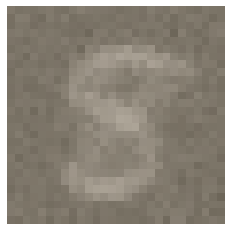

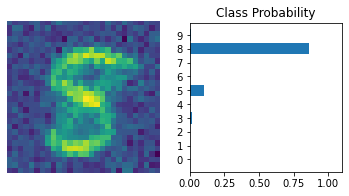

In [43]:
helper.imshow(p_img.squeeze(0))
predict(model, p_img)

In [22]:
helper.imshow(c_images[155].squeeze(0))
predict(model, c_images[155])

IndexError: list index out of range